# LIDAME - TP 2 - Attention


# Install and Import Dependencies


In [1]:
#!pip install tensorboard -q
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision import transforms
import numpy as np
import struct
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import os
import random
from collections import Counter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

2025-12-24 22:22:01.248181: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766614921.419480      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766614921.482271      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766614921.891953      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766614921.891993      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766614921.891996      55 computation_placer.cc:177] computation placer alr

Using device: cuda


# Setup Paths

In [2]:
IMAGES_PATH = '/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images'
CAPTIONS_FILE = '/kaggle/input/flickr-image-dataset/flickr30k_images/results.csv'
WORD2VEC_PATH = '/kaggle/input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin'

# Load Captions and Compute Vocabulary

In [3]:
captions_df = pd.read_csv(CAPTIONS_FILE, delimiter='|')
captions_df.columns = captions_df.columns.str.strip()
print(f"Captions loaded: {captions_df.shape}")
print(f"Columns: {captions_df.columns.tolist()}")

Captions loaded: (158915, 3)
Columns: ['image_name', 'comment_number', 'comment']


In [4]:
# Clean the data
captions_df = captions_df.dropna()
captions_df['image_name'] = captions_df['image_name'].str.strip()
captions_df['comment'] = captions_df['comment'].str.strip()

In [5]:
# Build vocabulary from captions
vocabulary = set()
vocabulary.add('<START>')
vocabulary.add('<END>')
vocabulary.add('<PAD>')
vocabulary.add('<UNK>')

for caption in captions_df['comment'].values:
    if isinstance(caption, str):
        for word in caption.lower().split():
            # Simple cleaning
            word = word.strip('.,!?;:"()[]')
            if word:
                vocabulary.add(word)

print(f"Number of words in vocabulary: {len(vocabulary)}")

Number of words in vocabulary: 20273


# Word2Vec Reading Functions

In [6]:
def read_until(open_file):
    while True:
        char = open_file.read(1)
        if char == b' ' or char == b'':
            break
        yield char

def read_word2vec():
    with open(WORD2VEC_PATH, "rb") as f:
        first_line = f.readline()
        n_words, n_dim = map(int, first_line.split())
        print(f"Loading Word2Vec: {n_words} words, {n_dim} dimensions")
        for n_word in range(n_words):
            word = b''.join(read_until(f)).decode('utf-8', errors='ignore')
            vector = struct.unpack('f' * n_dim, f.read(n_dim * 4))
            yield word, vector

print("Word2Vec reading functions defined")

Word2Vec reading functions defined


# Create Embedding Layer with Special Tokens

In [7]:
def create_embedding_layer(vocab, randomized=False):
    # Special tokens
    special_tokens = ['<PAD>', '<START>', '<END>', '<UNK>']
    idx_to_word = special_tokens.copy()
    word_to_idx = {word: idx for idx, word in enumerate(special_tokens)}
    
    if randomized:
        weights = [np.random.randn(300) for _ in special_tokens]
        for word in vocab:
            if word not in word_to_idx:
                idx_to_word.append(word)
                word_to_idx[word] = len(idx_to_word) - 1
                weights.append(np.random.randn(300))
        
        weights = np.array(weights)
        emb_layer = nn.Embedding(len(weights), 300)
        emb_layer.weight.data.copy_(torch.FloatTensor(weights))
        return emb_layer, idx_to_word, word_to_idx
    else:
        # Initialize special tokens with random vectors
        weights = [np.random.randn(300) for _ in special_tokens]
        
        # Load Word2Vec
        loaded_count = 0
        for word, vector in read_word2vec():
            if word in vocab and word not in word_to_idx:
                idx_to_word.append(word)
                word_to_idx[word] = len(idx_to_word) - 1
                weights.append(np.array(vector))
                loaded_count += 1
                
                if loaded_count % 10000 == 0:
                    print(f"Loaded {loaded_count} word vectors...")
        
        # Add remaining vocab words with random vectors
        for word in vocab:
            if word not in word_to_idx:
                idx_to_word.append(word)
                word_to_idx[word] = len(idx_to_word) - 1
                weights.append(np.random.randn(300))
        
        weights = np.array(weights)
        emb_layer = nn.Embedding(len(weights), 300)
        emb_layer.weight.data.copy_(torch.FloatTensor(weights))
        emb_layer.weight.requires_grad = False  # Freeze embeddings
        
        print(f"Loaded {loaded_count} words from Word2Vec")
        return emb_layer, idx_to_word, word_to_idx

print("Embedding layer function defined")

Embedding layer function defined


# Tokenization Functions with Special Tokens

In [8]:
def tokenize(sentence, word2idx, max_length=20):
    """Tokenize a sentence with START and END tokens"""
    tokens = [word2idx['<START>']]
    sentence = sentence.lower().strip()
    
    for word in sentence.split():
        word = word.strip('.,!?;:"()[]')
        if word:
            tokens.append(word2idx.get(word, word2idx['<UNK>']))
    
    tokens.append(word2idx['<END>'])
    
    # Truncate if too long
    if len(tokens) > max_length:
        tokens = tokens[:max_length-1] + [word2idx['<END>']]
    
    # Pad if too short
    while len(tokens) < max_length:
        tokens.append(word2idx['<PAD>'])
    
    return tokens

def untokenize(tokens, idx2word):
    """Convert tokens back to words, stopping at END token"""
    words = []
    for idx in tokens:
        word = idx2word[idx]
        if word == '<END>':
            break
        if word not in ['<PAD>', '<START>']:
            words.append(word)
    return ' '.join(words)

print("Tokenization functions defined")

Tokenization functions defined


# Load Embeddings

In [9]:
print("Loading embeddings...")
RANDOMIZED = False
pretrained_embeddings, idx2word, word2idx = create_embedding_layer(vocabulary, RANDOMIZED)
print(f"Vocabulary size: {len(idx2word)}")
print(f"Special tokens: PAD={word2idx['<PAD>']}, START={word2idx['<START>']}, END={word2idx['<END>']}, UNK={word2idx['<UNK>']}")

Loading embeddings...
Loading Word2Vec: 3000000 words, 300 dimensions
Loaded 10000 word vectors...
Loaded 16833 words from Word2Vec
Vocabulary size: 20273
Special tokens: PAD=0, START=1, END=2, UNK=3


# DATA PREPARATION

# Custom Flickr30k Dataset

In [10]:
class Flickr30kDataset(Dataset):
    def __init__(self, captions_df, images_path, transform=None):
        self.images_path = images_path
        self.transform = transform
        
        # Group captions by image
        self.image_to_captions = {}
        for idx, row in captions_df.iterrows():
            img_name = row['image_name']
            caption = row['comment']
            
            if pd.notna(img_name) and pd.notna(caption):
                if img_name not in self.image_to_captions:
                    self.image_to_captions[img_name] = []
                self.image_to_captions[img_name].append(caption)
        
        self.image_names = list(self.image_to_captions.keys())
        print(f"Dataset created with {len(self.image_names)} images")
    
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.images_path, img_name)
        
        try:
            image = Image.open(img_path).convert('RGB')
        except:
            print(f"Error loading image: {img_path}")
            # Return a blank image as fallback
            image = Image.new('RGB', (224, 224), color='white')
        
        if self.transform:
            image = self.transform(image)
        
        captions = self.image_to_captions[img_name]
        return image, captions, img_name

print("Custom Flickr30kDataset defined")

Custom Flickr30kDataset defined


# Apply Transformations with Normalization

In [11]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                       std=[0.229, 0.224, 0.225])
])
print("Transforms with normalization applied")

Transforms with normalization applied


# Load Dataset

In [12]:
full_dataset = Flickr30kDataset(captions_df, IMAGES_PATH, transform=transform)
print(f"Total dataset size: {len(full_dataset)}")

Dataset created with 31783 images
Total dataset size: 31783


In [13]:
full_dataset

In [14]:
captions_df

image_name comment_number  \
0       1000092795.jpg              0   
1       1000092795.jpg              1   
2       1000092795.jpg              2   
3       1000092795.jpg              3   
4       1000092795.jpg              4   
...                ...            ...   
158910   998845445.jpg              0   
158911   998845445.jpg              1   
158912   998845445.jpg              2   
158913   998845445.jpg              3   
158914   998845445.jpg              4   

                                                  comment  
0       Two young guys with shaggy hair look at their ...  
1       Two young , White males are outside near many ...  
2        Two men in green shirts are standing in a yard .  
3            A man in a blue shirt standing in a garden .  
4                 Two friends enjoy time spent together .  
...                                                   ...  
158910  A man in shorts and a Hawaiian shirt leans ove...  
158911  A young man hanging over the side of a boat , ...  
158912  A man is leaning off of the side of a blue and...  
158913  A man riding a small boat in a harbor , with f...  
158914  A man on a moored blue and white boat with hil...  

[158914 rows x 3 columns]

# Split Dataset (80/20)

In [15]:
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])
print(f"Train size: {len(train_dataset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 25426
Test size: 6357


# Collate Function

In [16]:
def collate_fn(batch):
    images = []
    captions = []
    img_names = []
    
    for img, caption_list, img_name in batch:
        images.append(img)
        # Randomly select one caption per image
        caption = random.choice(caption_list)
        tokenized = tokenize(caption, word2idx, max_length=20)
        captions.append(tokenized)
        img_names.append(img_name)
    
    images = torch.stack(images)
    captions = torch.LongTensor(captions)
    return images, captions, img_names

print("Collate function defined")

Collate function defined


# Create DataLoaders

In [17]:
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                         collate_fn=collate_fn, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                        collate_fn=collate_fn, num_workers=2, pin_memory=True)

print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 795
Test batches: 199


# Load ResNet50 Pre-trained

In [18]:
print("Loading ResNet50...")
resnet = torchvision.models.resnet50(weights='IMAGENET1K_V1')

Loading ResNet50...
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 190MB/s] 


# Modify ResNet50 - Remove last two layers

In [20]:
print("Modifying ResNet50...")
modules = list(resnet.children())[:-2]  # Remove avgpool and fc
resnet_modified = nn.Sequential(*modules)
print("ResNet50 modified (removed avgpool and fc)")

Modifying ResNet50...
ResNet50 modified (removed avgpool and fc)


# Freeze ResNet Parameters

In [21]:
for param in resnet_modified.parameters():
    param.requires_grad = False

print("ResNet parameters frozen")
print("Why freeze? Use ResNet as a fixed feature extractor, reduce training time and memory")

ResNet parameters frozen
Why freeze? Use ResNet as a fixed feature extractor, reduce training time and memory


# Attention Module

In [22]:
class AttentionModule(nn.Module):
    def __init__(self, feature_dim, hidden_dim, attention_dim):
        super(AttentionModule, self).__init__()
        self.feature_proj = nn.Linear(feature_dim, attention_dim)
        self.hidden_proj = nn.Linear(hidden_dim, attention_dim)
        self.attention = nn.Linear(attention_dim, 1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, features, hidden_state):
        # features: (batch, feature_dim, H, W)
        # hidden_state: (batch, hidden_dim)
        
        batch_size, feature_dim, H, W = features.size()
        
        # Reshape features: (batch, H*W, feature_dim)
        features_flat = features.view(batch_size, feature_dim, -1).permute(0, 2, 1)
        num_pixels = H * W
        
        # Project features: (batch, H*W, attention_dim)
        features_proj = self.feature_proj(features_flat)
        
        # Project and expand hidden state: (batch, H*W, attention_dim)
        hidden_proj = self.hidden_proj(hidden_state).unsqueeze(1).expand(-1, num_pixels, -1)
        
        # Compute attention scores
        combined = self.relu(features_proj + hidden_proj)
        attention_scores = self.attention(combined).squeeze(2)  # (batch, H*W)
        
        # Apply softmax
        attention_weights = self.softmax(attention_scores)  # (batch, H*W)
        
        # Compute context vector: (batch, feature_dim)
        context_vector = torch.bmm(attention_weights.unsqueeze(1), features_flat).squeeze(1)
        
        return context_vector, attention_weights

print("Improved AttentionModule implemented")

Improved AttentionModule implemented


# LSTM with Attention and Dropout

In [23]:
class LSTMWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size, attention_module, feature_dim, dropout=0.5):
        super(LSTMWithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.attention_module = attention_module
        
        # LSTM input: embedding + hidden + attention context
        lstm_input_size = input_size + hidden_size + feature_dim
        
        # LSTM gates
        self.W_i = nn.Linear(lstm_input_size, hidden_size)
        self.W_f = nn.Linear(lstm_input_size, hidden_size)
        self.W_c = nn.Linear(lstm_input_size, hidden_size)
        self.W_o = nn.Linear(lstm_input_size, hidden_size)
        
        self.dropout = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
    
    def forward(self, x, conv_features, hidden_state=None):
        # x: (batch, seq_len, input_size)
        # conv_features: (batch, feature_dim, H, W)
        
        batch_size, seq_len, _ = x.size()
        
        # Initialize hidden states
        if hidden_state is None:
            h_t = torch.zeros(batch_size, self.hidden_size, device=x.device)
            c_t = torch.zeros(batch_size, self.hidden_size, device=x.device)
        else:
            h_t, c_t = hidden_state
        
        outputs = []
        
        for t in range(seq_len):
            x_t = x[:, t, :]
            
            # Get attention context
            context_vector, _ = self.attention_module(conv_features, h_t)
            
            # Concatenate inputs
            combined = torch.cat([x_t, h_t, context_vector], dim=1)
            
            # LSTM gates
            i_t = self.sigmoid(self.W_i(combined))
            f_t = self.sigmoid(self.W_f(combined))
            c_tilde = self.tanh(self.W_c(combined))
            o_t = self.sigmoid(self.W_o(combined))
            
            # Update cell and hidden state
            c_t = f_t * c_t + i_t * c_tilde
            h_t = o_t * self.tanh(c_t)
            
            # Apply dropout
            h_t_drop = self.dropout(h_t)
            outputs.append(h_t_drop.unsqueeze(1))
        
        outputs = torch.cat(outputs, dim=1)
        return outputs, (h_t, c_t)
    
    def forward_step(self, x_t, conv_features, hidden_state):
        """Single step forward for generation"""
        h_t, c_t = hidden_state
        
        # Get attention context
        context_vector, att_weights = self.attention_module(conv_features, h_t)
        
        # Concatenate inputs
        combined = torch.cat([x_t, h_t, context_vector], dim=1)
        
        # LSTM gates
        i_t = self.sigmoid(self.W_i(combined))
        f_t = self.sigmoid(self.W_f(combined))
        c_tilde = self.tanh(self.W_c(combined))
        o_t = self.sigmoid(self.W_o(combined))
        
        # Update cell and hidden state
        c_t = f_t * c_t + i_t * c_tilde
        h_t = o_t * self.tanh(c_t)
        
        return h_t, (h_t, c_t), att_weights

print("LSTMWithAttention with dropout implemented")

LSTMWithAttention with dropout implemented


# Image Captioning Model

In [24]:

class ImageCaptioningModel(nn.Module):
    def __init__(self, cnn_model, embedding_model, lstm_hidden_dim, vocab_size, dropout=0.5):
        super(ImageCaptioningModel, self).__init__()
        self.cnn = cnn_model
        self.embedding = embedding_model
        self.vocab_size = vocab_size
        self.lstm_hidden_dim = lstm_hidden_dim
        
        # ResNet50 output: 2048 channels at 7x7
        feature_dim = 2048
        attention_dim = 512
        
        self.attention = AttentionModule(feature_dim, lstm_hidden_dim, attention_dim)
        
        embed_dim = embedding_model.weight.size(1)
        
        self.lstm = LSTMWithAttention(
            embed_dim, lstm_hidden_dim, self.attention, feature_dim, dropout=dropout
        )
        
        self.fc = nn.Linear(lstm_hidden_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, images, captions):
        # Extract features
        with torch.no_grad():
            conv_features = self.cnn(images)
        
        # Embed captions (excluding last token for teacher forcing)
        embedded = self.embedding(captions[:, :-1])
        
        # LSTM forward
        lstm_out, _ = self.lstm(embedded, conv_features)
        
        # Apply dropout before final layer
        lstm_out = self.dropout(lstm_out)
        
        # Predict next words
        predictions = self.fc(lstm_out)
        
        return predictions

print("ImageCaptioningModel implemented")

ImageCaptioningModel implemented


# Initialize Model

In [25]:
LSTM_HIDDEN_DIM = 512
DROPOUT = 0.5
vocab_size = len(idx2word)

model = ImageCaptioningModel(
    cnn_model=resnet_modified,
    embedding_model=pretrained_embeddings,
    lstm_hidden_dim=LSTM_HIDDEN_DIM,
    vocab_size=vocab_size,
    dropout=DROPOUT
).to(device)

print(f"Model initialized")
print(f"Vocabulary size: {vocab_size}")
print(f"LSTM hidden dim: {LSTM_HIDDEN_DIM}")
print(f"Dropout: {DROPOUT}")

Model initialized
Vocabulary size: 20273
LSTM hidden dim: 512
Dropout: 0.5


# Setup Training Parameters

In [26]:
learning_rate = 0.001
num_epochs = 50  # and not 1000 --------
weight_decay = 1e-5

# Ignore padding in loss
criterion = nn.CrossEntropyLoss(ignore_index=word2idx['<PAD>'])

# Only train non-frozen parameters
trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = optim.Adam(trainable_params, lr=learning_rate, weight_decay=weight_decay)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

writer = SummaryWriter('runs/image_captioning_fixed')

print("Training setup complete")
print(f"Learning rate: {learning_rate}")
print(f"Epochs: {num_epochs}")
print(f"Weight decay: {weight_decay}")
print(f"Scheduler: StepLR(step_size=10, gamma=0.5)")

Training setup complete
Learning rate: 0.001
Epochs: 50
Weight decay: 1e-05
Scheduler: StepLR(step_size=10, gamma=0.5)


# Generate Caption Function

In [27]:
def generate_caption(model, image, idx2word, word2idx, max_length=20, temperature=1.0):
    """Generate caption with proper autoregressive decoding"""
    model.eval()
    with torch.no_grad():
        # Extract features
        if image.dim() == 3:
            image = image.unsqueeze(0)
        conv_features = model.cnn(image)
        
        batch_size = 1
        
        # Initialize with START token
        current_token = torch.LongTensor([[word2idx['<START>']]]).to(device)
        
        # Initialize LSTM hidden state
        h_t = torch.zeros(batch_size, model.lstm_hidden_dim, device=device)
        c_t = torch.zeros(batch_size, model.lstm_hidden_dim, device=device)
        
        generated_tokens = []
        
        for _ in range(max_length):
            # Embed current token
            embedded = model.embedding(current_token).squeeze(1)
            
            # LSTM step
            h_t, (h_t, c_t), _ = model.lstm.forward_step(embedded, conv_features, (h_t, c_t))
            
            # Predict next token
            output = model.fc(h_t)
            
            # Apply temperature
            output = output / temperature
            
            # Get most likely token
            next_token = output.argmax(dim=1).item()
            
            # Stop if END token
            if next_token == word2idx['<END>']:
                break
            
            # Avoid PAD and START tokens
            if next_token in [word2idx['<PAD>'], word2idx['<START>']]:
                break
            
            generated_tokens.append(next_token)
            current_token = torch.LongTensor([[next_token]]).to(device)
        
        return untokenize(generated_tokens, idx2word)

print("Generate caption function (CORRECTED) defined")

Generate caption function (CORRECTED) defined


# Training Loop with Early Stopping

In [21]:
print("Starting training...")

best_test_loss = float('inf')
patience = 5
patience_counter = 0
global_step = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    
    for batch_idx, (images, captions, _) in enumerate(train_loader):
        images = images.to(device)
        captions = captions.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        predictions = model(images, captions)
        
        # Reshape for loss computation
        predictions = predictions.reshape(-1, vocab_size)
        targets = captions[:, 1:].reshape(-1)  # Shift targets by 1
        
        # Compute loss
        loss = criterion(predictions, targets)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping to prevent explosion
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        
        optimizer.step()
        
        train_loss += loss.item()
        
        # Log every 10 iterations
        if batch_idx % 10 == 0:
            writer.add_scalar('Loss/train_step', loss.item(), global_step)
            global_step += 1
        
        if batch_idx % 50 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}")
    
    avg_train_loss = train_loss / len(train_loader)
    writer.add_scalar('Loss/train_epoch', avg_train_loss, epoch)
    
    # Evaluation on test set
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for images, captions, _ in test_loader:
            images = images.to(device)
            captions = captions.to(device)
            
            predictions = model(images, captions)
            predictions = predictions.reshape(-1, vocab_size)
            targets = captions[:, 1:].reshape(-1)
            
            loss = criterion(predictions, targets)
            test_loss += loss.item()
    
    avg_test_loss = test_loss / len(test_loader)
    writer.add_scalar('Loss/test', avg_test_loss, epoch)
    
    # Generate example captions
    sample_image, _, _ = test_dataset[0]
    sample_image = sample_image.to(device)
    generated_caption = generate_caption(model, sample_image, idx2word, word2idx)
    
    print(f"\n{'='*80}")
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")
    print(f"Generated Caption: {generated_caption}")
    print(f"Learning Rate: {scheduler.get_last_lr()[0]:.6f}")
    print(f"{'='*80}\n")
    
    # Step scheduler
    scheduler.step()
    
    # Early stopping
    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        patience_counter = 0
        # Save best model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': avg_train_loss,
            'test_loss': avg_test_loss,
        }, 'best_model.pth')
        print("✓ Best model saved!")
    else:
        patience_counter += 1
        print(f"Patience: {patience_counter}/{patience}")
        
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break
    
    # Save checkpoint every 5 epochs
    if (epoch + 1) % 5 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': avg_train_loss,
            'test_loss': avg_test_loss,
        }, f'checkpoint_epoch_{epoch+1}.pth')

writer.close()
print("Training complete!")

Starting training...
Epoch [1/50], Batch [0/795], Loss: 9.9269
Epoch [1/50], Batch [50/795], Loss: 6.3568
Epoch [1/50], Batch [100/795], Loss: 5.9870
Epoch [1/50], Batch [150/795], Loss: 5.8054
Epoch [1/50], Batch [200/795], Loss: 5.7009
Epoch [1/50], Batch [250/795], Loss: 5.2070
Epoch [1/50], Batch [300/795], Loss: 4.9182
Epoch [1/50], Batch [350/795], Loss: 4.9605
Epoch [1/50], Batch [400/795], Loss: 5.1518
Epoch [1/50], Batch [450/795], Loss: 5.3345
Epoch [1/50], Batch [500/795], Loss: 4.8649
Epoch [1/50], Batch [550/795], Loss: 5.0229
Epoch [1/50], Batch [600/795], Loss: 4.9282
Epoch [1/50], Batch [650/795], Loss: 4.8503
Epoch [1/50], Batch [700/795], Loss: 4.9128
Epoch [1/50], Batch [750/795], Loss: 4.9970

Epoch [1/50]
Train Loss: 5.3011, Test Loss: 4.6107
Generated Caption: a man in a blue shirt is in a blue shirt and a man
Learning Rate: 0.001000

✓ Best model saved!
Epoch [2/50], Batch [0/795], Loss: 4.9269
Epoch [2/50], Batch [50/795], Loss: 4.9294
Epoch [2/50], Batch [100/7

# Load Best Model

In [22]:
print("Loading best model...")
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Best model from epoch {checkpoint['epoch']+1} loaded")
print(f"Best test loss: {checkpoint['test_loss']:.4f}")

Loading best model...
Best model from epoch 50 loaded
Best test loss: 3.4157


# Test Caption Generation

In [23]:
print("\n" + "="*80)
print("TESTING CAPTION GENERATION")
print("="*80 + "\n")

model.eval()
num_examples = 10

for i in range(num_examples):
    sample_image, sample_captions, img_name = test_dataset[i]
    sample_image = sample_image.to(device)
    
    generated = generate_caption(model, sample_image, idx2word, word2idx)
    actual = sample_captions[0]
    
    print(f"Example {i+1}:")
    print(f"Image: {img_name}")
    print(f"Generated: {generated}")
    print(f"Actual:    {actual}")
    print("-" * 80)


TESTING CAPTION GENERATION

Example 1:
Image: 3667908724.jpg
Generated: a woman in a white shirt and a black shirt is standing on a bench
Actual:    A young girl in a white dance outfit and black shoes is dancing in front of music equipment
--------------------------------------------------------------------------------
Example 2:
Image: 1348278340.jpg
Generated: a man in a black shirt is playing a guitar
Actual:    A man is singing into a microphone while standing on a stage with instruments and musical equipment on the floor around him .
--------------------------------------------------------------------------------
Example 3:
Image: 4859059617.jpg
Generated: a woman in a pink dress is walking down a street
Actual:    Two little girls , one in a purple dress and one in a red , polka-dotted dress , are running around an area covered in paving stones .
--------------------------------------------------------------------------------
Example 4:
Image: 3678098428.jpg
Generated: a man in

# Visualize Results with Denormalization

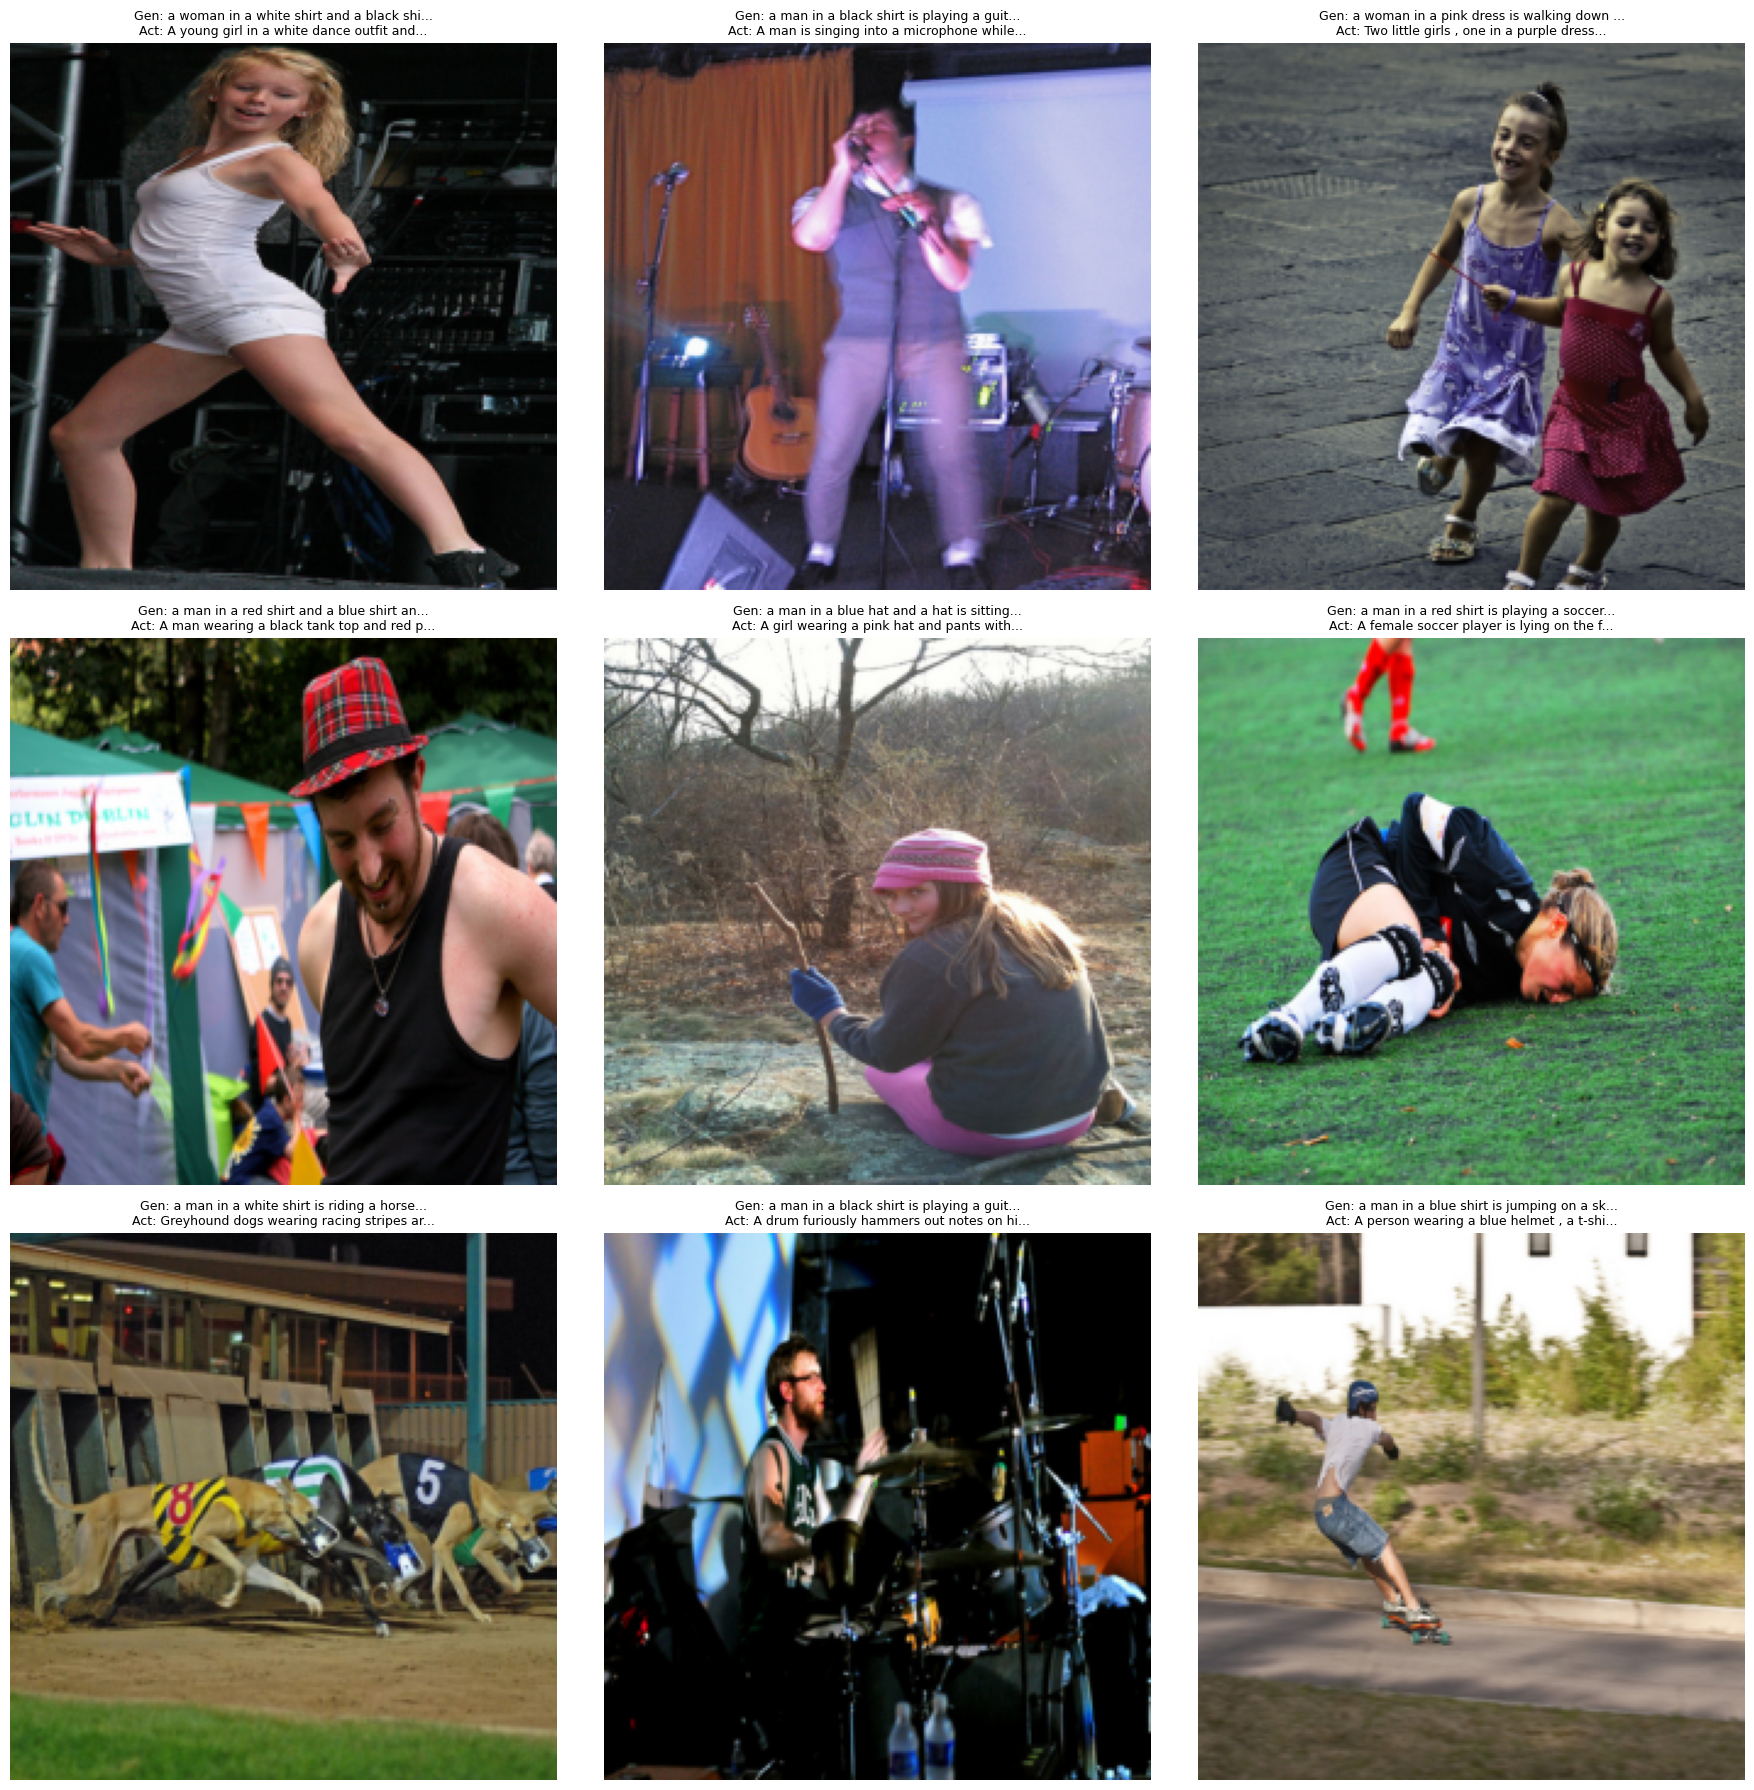


Visualization saved as 'caption_results.png'


In [24]:
def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """Denormalize image tensor"""
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return torch.clamp(tensor, 0, 1)

fig, axes = plt.subplots(3, 3, figsize=(18, 18))
axes = axes.flatten()

for i in range(9):
    sample_image, sample_captions, img_name = test_dataset[i]
    
    sample_image_device = sample_image.to(device)
    generated = generate_caption(model, sample_image_device, idx2word, word2idx)
    actual = sample_captions[0]
    
    # Denormalize image
    img = denormalize(sample_image)
    img = img.permute(1, 2, 0).cpu().numpy()
    
    axes[i].imshow(img)
    axes[i].set_title(f"Gen: {generated[:40]}...\nAct: {actual[:40]}...", fontsize=9)
    axes[i].axis('off')

plt.tight_layout()
plt.savefig('caption_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nVisualization saved as 'caption_results.png'")

# Compute Caption Statistics

In [25]:
print("\n" + "="*80)
print("CAPTION STATISTICS")
print("="*80)

generated_captions = []
model.eval()

for i in range(min(100, len(test_dataset))):
    sample_image, _, _ = test_dataset[i]
    sample_image = sample_image.to(device)
    generated = generate_caption(model, sample_image, idx2word, word2idx)
    generated_captions.append(generated)

# Word frequency
all_words = []
for caption in generated_captions:
    all_words.extend(caption.split())

word_freq = Counter(all_words)
print(f"\nTotal generated captions: {len(generated_captions)}")
print(f"Unique words used: {len(word_freq)}")
print(f"Average caption length: {np.mean([len(c.split()) for c in generated_captions]):.2f} words")
print(f"\nTop 20 most common words:")
for word, count in word_freq.most_common(20):
    print(f"  {word}: {count}")

print("\n" + "="*80)
print("Training and evaluation complete!")
print("="*80)


CAPTION STATISTICS

Total generated captions: 100
Unique words used: 86
Average caption length: 11.95 words

Top 20 most common words:
  a: 313
  in: 110
  shirt: 100
  is: 85
  man: 70
  blue: 42
  on: 40
  and: 30
  red: 30
  standing: 29
  sitting: 23
  white: 22
  black: 20
  of: 18
  walking: 16
  bench: 15
  down: 15
  people: 14
  woman: 13
  street: 13

Training and evaluation complete!
